In [105]:
import matplotlib.pyplot as plt
import pyGMs as gm
import numpy as np
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import pyro.poutine as poutine

import pandas as pd

seed = 123
pyro.set_rng_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [106]:
data = pd.read_csv('data.csv')

data = data[["winner", "loser"]]
data["win"] = .1

In [124]:
dataset = list(data.itertuples(index=False, name=None))

teams = set()
for match in dataset:
    teams.add(match[0])
    teams.add(match[1])

teams = {v: i for i, v in enumerate(list(teams))}
dataset = [(teams[winner], teams[loser], win)
           for winner, loser, win in dataset]

In [108]:
def model(matches, n_teams):
    X = [pyro.sample(f"X{i}", dist.Normal(0, 1)) for i in range(n_teams)]

    for i, m in enumerate(matches):
        pyro.sample(f"w{i}",
                    dist.Bernoulli(logits=X[m[0]]-X[m[1]]),
                    obs=torch.tensor(1.))

In [109]:
nuts_kernel = pyro.infer.NUTS(model, jit_compile=False)
mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=2000,
                       warmup_steps=100, num_chains=1)
mcmc.run(dataset, len(teams))

Sample: 100%|██████████| 60/60 [00:51,  1.16it/s, step size=2.51e-01, acc. prob=0.763]


In [135]:
score_board = [0]*len(teams)

for m in dataset:
    score_board[m[0]] += 1
    score_board[m[1]] -= 1

score_board = sorted(list(enumerate(score_board)),
                     key=lambda x: x[1], reverse=True)

naive_ranking = [x[0] for x in score_board]

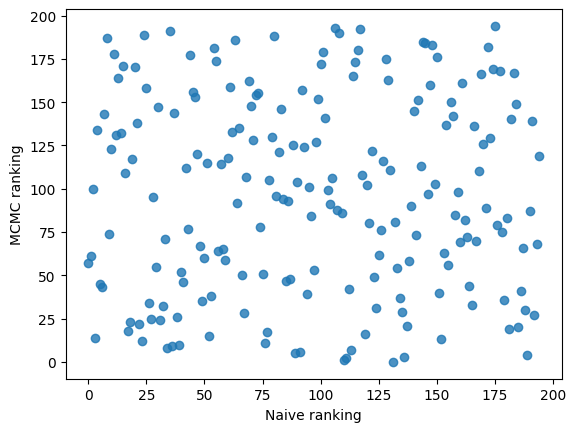

In [152]:
samples = mcmc.get_samples(10000)
mcmc_ranking = sorted(
    naive_ranking, key=lambda i: samples[f'X{i}'].mean(), reverse=True)

plt.plot(naive_ranking, mcmc_ranking, 'o', alpha=0.8, label="Naive")
plt.xlabel("Naive ranking")
plt.ylabel("MCMC ranking")

plt.show()